<a href="https://colab.research.google.com/github/rupontn/DataScience/blob/master/heart_sound_classification_challenge_ruponti_nath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Sound Machine Learning Challenge

This challenge is based on the [Physionet 2016 machine learning challenge](https://physionet.org/content/challenge-2016/1.0.0/). Numerous solutions to this challenge have been published and we encourage you to take advantage of previous work. We don't expect this exercise to take more than four hours. But there is a space at the end of the notebook to discuss other techniques you would try if you had more time. 

## Training Data

The training set for this challenge consists of the training data from the Physionet 2016 minus the data included in the test set. There is a file named REFERENCE.csv containing the audio file names and the corresponding labels. The meaning of the labels are as follows: 

```
Abnormal heart sound: 1
Normal heart sound: -1 
```

While training if you would like access to GPU or TPU hardware, you can select `Change runtime type` from the `Runtime` menu and select an accelerator type under `Hardware accelerator`. 

## Test Data

The test set data consists 301 recordings from the public validation set from the Physionet 2016 challenge. This is a balanced set of 150 normal and 151 abnormal recordings. We encourage you to not use this set for hyperparameter tuning and to save it to evaluate on at the end of the challenge.

## Evaluation

Tune your solutions to maximize the area under the ROC curve for detection of abnormal heart sounds. We will attempt to evaluate your model both on the test set provided and on a hidden holdout set. 

## Deliverable

Feel free to make any changes you like to the preprocessing or the classifier. Please share your updated colab notebook with the hiring manager. To help us understand your results, you can include explanations of the experiments you've performed and improvements that you've made using the colab notebook's text blocks. There is also a text block at the end of the notebook for you to summarize your changes. 

In [ ]:
import os

import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.io import wavfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Reshape, Add, Activation, multiply, SpatialDropout1D, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping
import tensorflow as tf
from livelossplot import PlotLossesKeras


tf.random.set_seed(2)

In [ ]:
!pip install livelossplot


# Download and preprocess data

In [ ]:
! wget https://eko-public.s3.amazonaws.com/heart_sound_challenge.zip
! unzip -q heart_sound_challenge.zip

--2021-11-04 15:52:27--  https://eko-public.s3.amazonaws.com/heart_sound_challenge.zip
Resolving eko-public.s3.amazonaws.com (eko-public.s3.amazonaws.com)... 52.217.93.60
Connecting to eko-public.s3.amazonaws.com (eko-public.s3.amazonaws.com)|52.217.93.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163941805 (156M) [application/zip]
Saving to: ‘heart_sound_challenge.zip’

heart_sound_challen 100%[===================>] 156.35M  45.7MB/s    in 3.9s    

2021-11-04 15:52:31 (40.4 MB/s) - ‘heart_sound_challenge.zip’ saved [163941805/163941805]



In [ ]:
TRAIN_PATH = 'heart_sound_challenge/train/'
TEST_PATH = 'heart_sound_challenge/test/'

def preprocess_data(PATH):
  # Load data reference
  labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))

  # Plug input data into numpy array
  x = np.zeros((len(labels), 2000*5, 1)) 
  for k, recording_id in enumerate(labels.recording_id):
    fs, audio = wavfile.read(os.path.join(PATH, recording_id + '.wav'))
    assert(fs == 2000)
    x[k, :, 0] = audio[:2000*5]/(2**15-1) 
    
  # Plug labels into numpy array
  y = pd.get_dummies(labels.label).values

  return x, y

x_train, y_train = preprocess_data(TRAIN_PATH)
x_test,  y_test  = preprocess_data(TEST_PATH)
print(x_train.dtype)
print(y_train.dtype)
print(x_train.shape)
print(y_train.shape)




float64
uint8
(2939, 10000, 1)
(2939, 2)


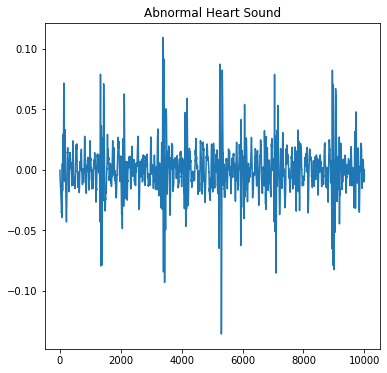

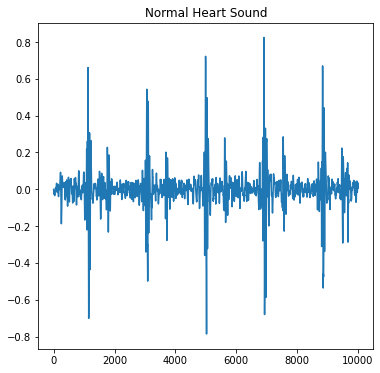

Number of abnormal heart sound in training data : 514
Number of normal heart sound in training data : 2425


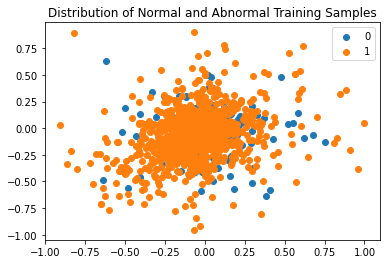

In [ ]:
## Data Visualization

plt.figure(figsize=(6, 6))
plt.plot(x_train[0,:,:])
plt.title('Abnormal Heart Sound')
#fig= plt.figure(figsize=(6, 6))
#ax = fig.add_axes([0,0,1,1])
#ax.bar(y_train[1,:])
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(x_train[73,:,:])
plt.title('Normal Heart Sound')
#fig= plt.figure(figsize=(6, 6))
#ax = fig.add_axes([0,0,1,1])
#ax.bar(y_train[1,:])
plt.show()


#print(y_train[73,:])
#Counting the number of normal and abnormal heart sound in training data
count1=0

for i in range(2939):
  if y_train[i,0]==y_train[0,0]:
    count1= count1+1
  
print("Number of abnormal heart sound in training data : %d" %count1)
print("Number of normal heart sound in training data : %d" %(x_train.shape[0]-count1))


for i in range(2):
	samples_ix = where(y_train[:,0] == i)
	plt.scatter(x_train[samples_ix, 50], x_train[samples_ix, 100], label=str(i))
plt.legend()
plt.title("Distribution of Normal and Abnormal Training Samples")
plt.show()

Training dataset consists of 2939 samples of normal and abnormal heart sounds.  From calculation there are 514 abnormal sound and 2425 normal sound which indicates an imbalanced dataset for training with a ratio of 1:5 between two catgories. Scatter plot of two categories of sound also displays imbalanced distribution. To tackle this, cost sensitive learning by upweighting is performed by increasing the weight of one class as factor of 5 and keeping the weight of other class as 1.

Additionally, data augmentation is performed on the total training dataset by adding random gaussion noise and time series shifting. 

(32329, 10000, 1)
(32329, 2)
(8817, 10000, 1)
(8817, 2)
(38207, 10000, 1)
(38207, 2)


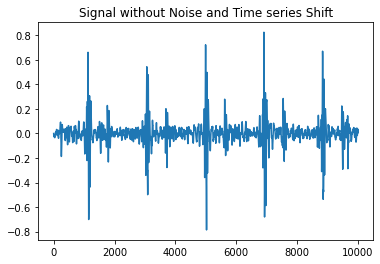

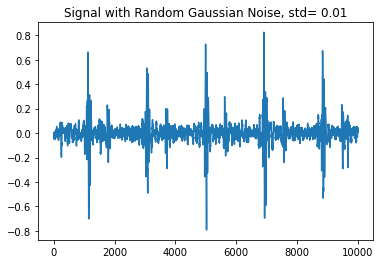

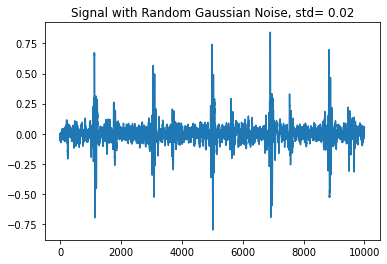

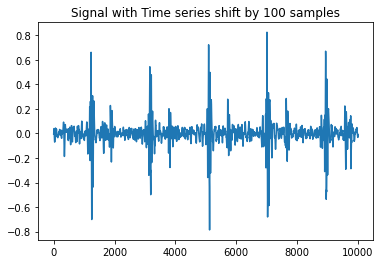

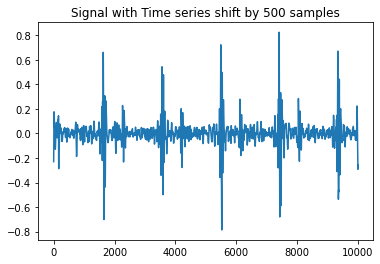

In [ ]:
## data Augmentation

def add_noise(x,factor):
  x2= np.zeros((x.shape[0],x.shape[1],x.shape[2]),dtype=float)
  noise= np.random.randn(x.shape[0],x.shape[1],x.shape[2])
  x2= x+ factor*noise
  return x2

def add_shift(x,shift):
  x2= np.zeros((x.shape[0],x.shape[1],x.shape[2]),dtype=float)
  x2= np.roll(x, shift, axis=1)
  return x2

def noise_augmentation(x,y,factor,scale):
  x1= np.zeros((x.shape[0]*(scale+1),x.shape[1],x.shape[2]),dtype=float)
  y1= np.zeros((y.shape[0]*(scale+1),y.shape[1]),dtype=int)
  x1[0:x.shape[0],:,:]= x[:,:,:]
  y1[0:y.shape[0],:]= y[:,:]

  for i in range(scale):
    x1[x.shape[0]*(i+1):(x.shape[0]*(i+2)),:,:]= add_noise(x,factor*(i+1))
    y1[y.shape[0]*(i+1):(y.shape[0]*(i+2)),:]= y[:,:]

  return x1,y1

def shift_augmentation(x,y,shift,scale):
  x1= np.zeros((x.shape[0]*(scale+1),x.shape[1],x.shape[2]),dtype=float)
  y1= np.zeros((y.shape[0]*(scale+1),y.shape[1]),dtype=int)
  x1[0:x.shape[0],:,:]= x[:,:,:]
  y1[0:y.shape[0],:]= y[:,:]

  for i in range(scale):
    x1[x.shape[0]*(i+1):(x.shape[0]*(i+2)),:,:]= add_shift(x,shift*(i+1))
    y1[y.shape[0]*(i+1):(y.shape[0]*(i+2)),:]= y[:,:]

  return x1,y1

#Training dataset are created by noise augmentaton and time shift augmentation. 
#To check the effect of augmentation on training they are created separately. 
#[x1_train, y1_train] are noise augmented dataset. 
#[x2_train, y2_train] are shift augmented dataset
#[x3_train, y3_train] are dataset where both augmentation is used. 
[x1_train, y1_train]= noise_augmentation(x_train, y_train,0.01,2)
[x2_train, y2_train]= shift_augmentation(x_train, y_train,100,10)

x3_train= np.zeros((x1_train.shape[0]+x2_train.shape[0]-2939,x1_train.shape[1],x1_train.shape[2]),dtype=float)
y3_train= np.zeros((y1_train.shape[0]+y2_train.shape[0]-2939,y1_train.shape[1]),dtype=int)

x3_train[0:x1_train.shape[0],:,:]= x1_train[:,:,:]
x3_train[x1_train.shape[0]:,:,:]= x2_train[2939:,:,:]

y3_train[0:y1_train.shape[0],:]= y1_train[:,:]
y3_train[y1_train.shape[0]:,:]= y2_train[2939:,:]


print(x2_train.shape)
print(y2_train.shape)
print(x1_train.shape)
print(y1_train.shape)
print(x3_train.shape)
print(y3_train.shape)


f=plt.figure(1)
plt.plot(x_train[73,:,:])
plt.title('Signal without Noise and Time series Shift')
plt.show()
f=plt.figure(2)
plt.plot(x1_train[2939+73,:,:])
plt.title('Signal with Random Gaussian Noise, std= 0.01')
plt.show()
f=plt.figure(3)
plt.plot(x1_train[2939+73+2939,:,:])
plt.title('Signal with Random Gaussian Noise, std= 0.02')
plt.show()

f=plt.figure(4)
plt.plot(x2_train[2939+73,:,:])
plt.title('Signal with Time series shift by 100 samples')
plt.show()

f=plt.figure(5)
plt.plot(x2_train[2939*5+73,:,:])
plt.title('Signal with Time series shift by 500 samples')
plt.show()


Data Augmentation is performed by adding gaussian random noise and time series shift in the signal. gaussian random noise with standard deviation 0.01 and 0.02 is used. From observation and trial and error, standard deviation 0.03 and higher, distorts the signals too much (particularly, signal with lower amplitude) and worsen the classifiction performance than the initial performance. Time series augmentation is performed by shifting the samples in right direction, started from 100 samples upto 1000 samples with 100 sample interval.  

Now network is trained with the given network and given hyperparameter.  



In [ ]:
batch_size = 128
num_classes = 2
epochs = 15


In [ ]:
def get_net_initial():

  model = Sequential()
  model.add(Conv1D(32, 5, activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(Conv1D(32, 5, activation='relu'))
  #model.add(Conv1D(32, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=(5)))

  model.add(Conv1D(64, 5, activation='relu'))
  model.add(Conv1D(64, 5, activation='relu'))
  #model.add(Conv1D(64, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=(5)))

  model.add(Conv1D(128, 5, activation='relu'))
  model.add(Conv1D(128, 5, activation='relu'))
  #model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=(5)))

  model.add(Conv1D(128, 5, activation='relu'))
  model.add(Conv1D(128, 5, activation='relu'))
  #model.add(Conv1D(128, 5, activation='relu'))
  model.add(MaxPooling1D(pool_size=(5)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))
  model.summary()
  return model


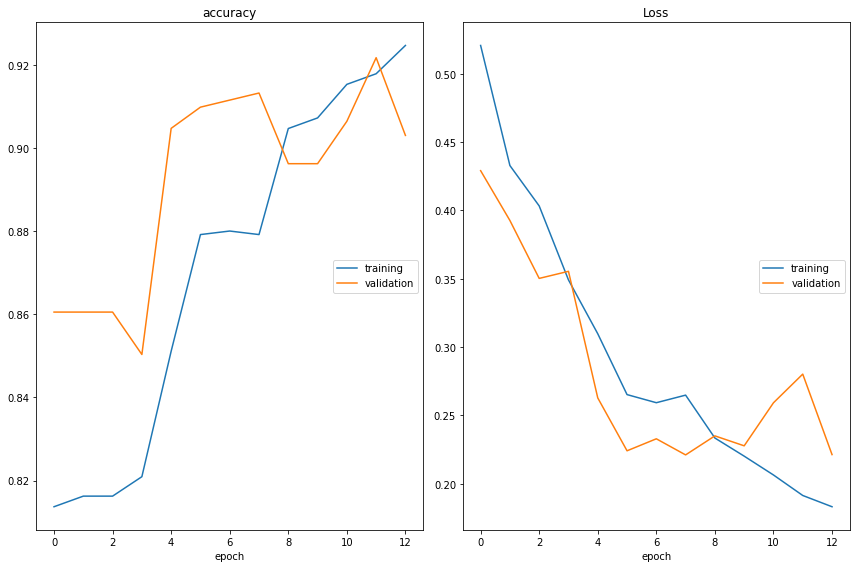

accuracy
	training         	 (min:    0.814, max:    0.925, cur:    0.925)
	validation       	 (min:    0.850, max:    0.922, cur:    0.903)
Loss
	training         	 (min:    0.183, max:    0.521, cur:    0.183)
	validation       	 (min:    0.221, max:    0.429, cur:    0.221)
Epoch 00013: early stopping


In [ ]:

model= get_net_initial()
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07),
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[es, PlotLossesKeras()],
    validation_split=0.2,
    verbose=1,
    shuffle=True,
)


In [ ]:
y_pred = model.predict(x_test)

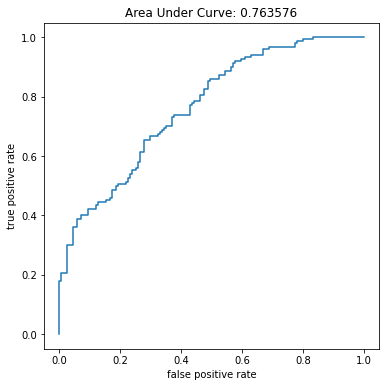

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_test[:, 0], y_pred[:, 0])

#sensitivity= (100*true_positive_rate)/(true_positive_rate+false_positive_rate)
#print(auc)
#print(sensitivity)

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

So the given network performance is AUC= ~0.76. As the training samples are imbalanced in nature. Now the same given model will be trained with added class weight. 

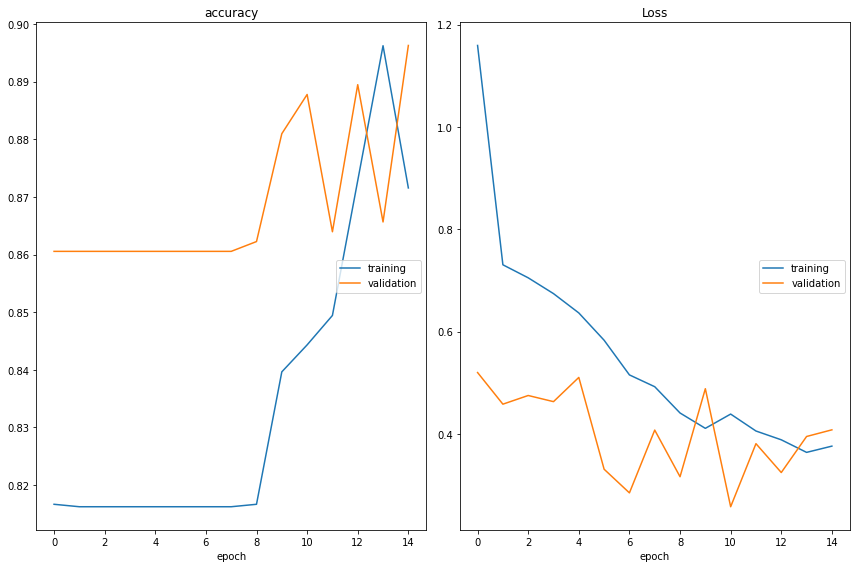

accuracy
	training         	 (min:    0.816, max:    0.896, cur:    0.872)
	validation       	 (min:    0.861, max:    0.896, cur:    0.896)
Loss
	training         	 (min:    0.364, max:    1.159, cur:    0.376)
	validation       	 (min:    0.257, max:    0.520, cur:    0.408)


In [ ]:
model= get_net_initial()
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07),
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
weights= {0:5, 1:1}

history = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[es, PlotLossesKeras()],
    class_weight= weights,
    validation_split=0.2,
    verbose=1,
    shuffle=True,
)

In [ ]:
y_pred = model.predict(x_test)

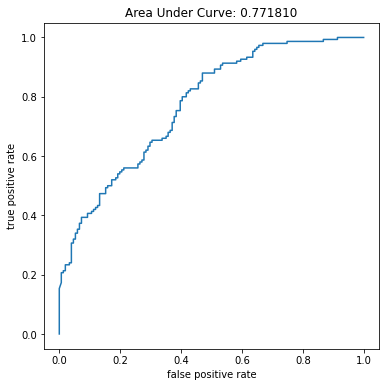

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_test[:, 0], y_pred[:, 0])

#sensitivity= (100*true_positive_rate)/(true_positive_rate+false_positive_rate)
#print(auc)
#print(sensitivity)

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

So, Added weight slightly improve the result from the initial given code. 

The given network results AUC 0.77 with added weight. The given network is a 1D encoder network with 4 maxpooling and 2 convolution layer before each maxpooling. From observation, if convolution layer is increased before each maxpooling the AUC is decreased due to gradient vanishing problem. To handle gradient vanshing problem one of the techniques is to use residual network. So instead of convolution layer, another encoder network is used which consists of residual block before each maxpooling. Each residual block consists of 4 convolutional layer and before each maxpooling two residual blocks are used. However, these increased the network parameter and when the network is trained without any augmentation in the training data, the AUC decreased with value around ~0.66. But when network is trained with augmented dataset with adjusted hyperparameter, AUC increased. After each residual block a channel attention is used to give weight to the important channels from the output of Residual block before maximum pooling. The resulted AUC from the residual block+ attention block encoder network is AUC= ~0.83. From experiment, performance without channel attention is slightly lower than the before, AUC= ~0.81

In [ ]:
batch_size = 256
num_classes = 2
epochs = 30
input_shape=(10000, 1)

In [ ]:
## here an encoder network is used where instead of convolution layer residual blocks+channel attention is used. two residal blocks
#and channel attention is used before each maxpooling.  

def channel_attention(input_feature, ratio=1):
  channel = input_feature.shape[2]
  shared_layer_one = Dense(channel // ratio,
                           activation='relu',
                           kernel_initializer='he_normal',
                           use_bias= True,
                           bias_initializer= 'zeros'
                           )
  avg_pool = GlobalAveragePooling1D()(input_feature)
  avg_pool = Reshape((1, channel))(avg_pool)
  avg_pool = shared_layer_one(avg_pool)

  max_pool = GlobalMaxPooling1D()(input_feature)
  max_pool = Reshape((1, channel))(max_pool)
  max_pool = shared_layer_one(max_pool)
  c_feature = Add()([avg_pool, max_pool])
  c_feature = Activation('sigmoid')(c_feature)
  return multiply([input_feature, c_feature])

def relu_bn(inputs):
  relu = tf.keras.layers.ReLU()(inputs)
  bn = BatchNormalization()(relu)
  return bn

def residual_block(x, kernel_size):
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)              
  y = relu_bn(y)
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)
  y = relu_bn(y)
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)
  y = relu_bn(y)
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)
  y = relu_bn(y) 
   
    
  out = Add()([x, y])
  out = relu_bn(out)
  return out

def get_net():

  inputs = Input(shape= (10000,1))


  #weights_initializer = RandomNormal(
          #mean=0.0, stddev=.01)
  conv1 = Conv1D(32, 5 , activation= 'relu')(inputs)
  conv1 = residual_block(conv1, 32)
  conv1 = residual_block(conv1, 32)
  conv1= SpatialDropout1D(0.2)(conv1)
  conv1= channel_attention(conv1)
  pool1 = MaxPooling1D(pool_size=(5))(conv1)

  conv2 = Conv1D(64, 5 , activation= 'relu')(pool1)
  conv2 = residual_block(conv2, 64)
  conv2 = residual_block(conv2, 64)
  conv2= SpatialDropout1D(0.2)(conv2)
  conv2= channel_attention(conv2)
  pool2 = MaxPooling1D(pool_size=(5))(conv2)

  conv3 = Conv1D(128, 5 , activation= 'relu')(pool2)
  conv3 = residual_block(conv3, 128)
  conv3 = residual_block(conv3, 128)
  conv3= SpatialDropout1D(0.2)(conv3)
  conv3= channel_attention(conv3)
  pool3 = MaxPooling1D(pool_size=(5))(conv3)

  conv4 = Conv1D(128, 5 , activation= 'relu')(pool3)
  conv4 = residual_block(conv4, 128)
  conv4 = residual_block(conv4, 128)
  conv4= SpatialDropout1D(0.2)(conv4)
  conv4= channel_attention(conv4)
  pool4 = MaxPooling1D(pool_size=(5))(conv4)

  i= Flatten()(pool4)
  h= Dense(256, activation='relu')(i)
  h= Dropout(0.5)(h)
  h= Dense(num_classes, activation=Activation(tf.nn.softmax))(h)
  model= Model(inputs= [inputs], outputs= [h])
  model.summary()
  return model


    

# Evaluate the model based on area under the ROC curve

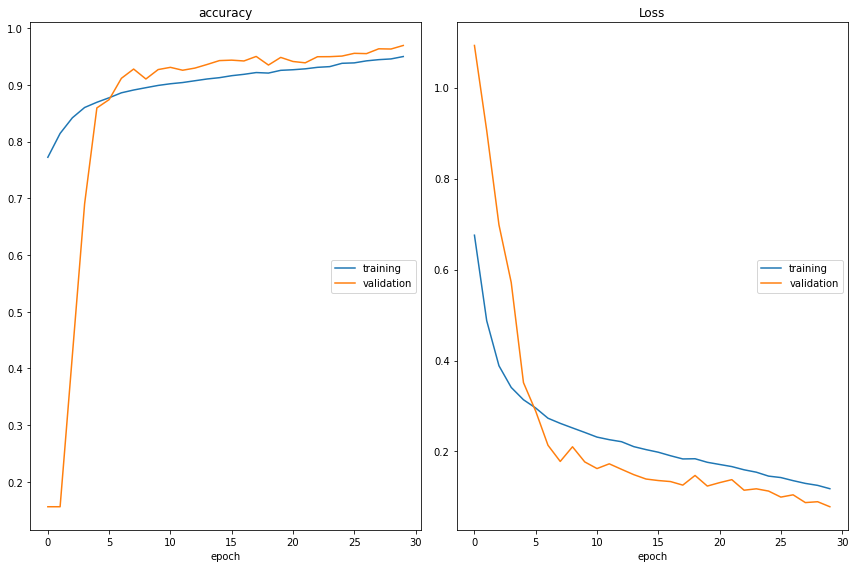

accuracy
	training         	 (min:    0.773, max:    0.950, cur:    0.950)
	validation       	 (min:    0.156, max:    0.970, cur:    0.970)
Loss
	training         	 (min:    0.118, max:    0.675, cur:    0.118)
	validation       	 (min:    0.079, max:    1.093, cur:    0.079)


In [ ]:
model= get_net()
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07),
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
weights= {0:5, 1:1}
history = model.fit(
    x3_train, 
    y3_train,
    #class_weight= weights,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[es, PlotLossesKeras()],
    verbose=1,
    validation_split=0.2,
    shuffle=True,
)

In [ ]:
y_pred = model.predict(x_test)

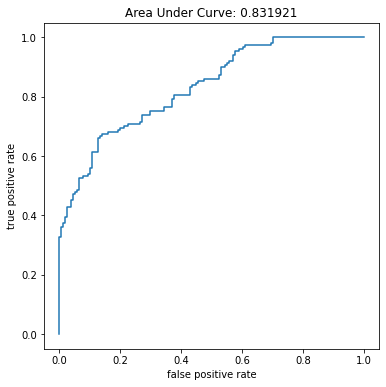

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_test[:, 0], y_pred[:, 0])

#sensitivity= (100*true_positive_rate)/(true_positive_rate+false_positive_rate)
#print(auc)
#print(sensitivity)

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()


So, from results, residual+channel attention encoder network gives improved performance. However, when data augmentation was used, class weight was not used in the training. In the following,  class weight is added with augmented training data to check if adding class weight  improve  the result or not.   

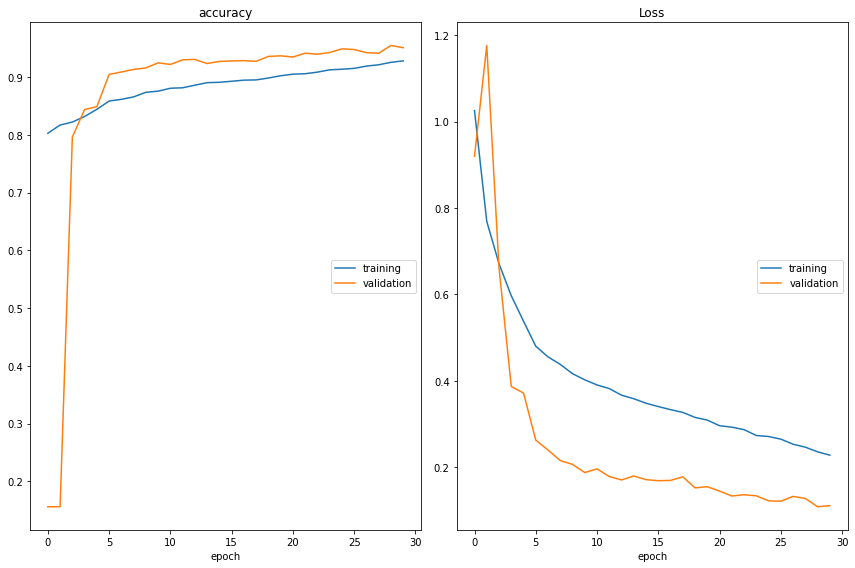

accuracy
	training         	 (min:    0.803, max:    0.928, cur:    0.928)
	validation       	 (min:    0.156, max:    0.955, cur:    0.951)
Loss
	training         	 (min:    0.228, max:    1.025, cur:    0.228)
	validation       	 (min:    0.108, max:    1.176, cur:    0.111)


In [ ]:

model= get_net()
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07),
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
weights= {0:3, 1:1}
history = model.fit(
    x3_train, 
    y3_train,
    class_weight= weights,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[es, PlotLossesKeras()],
    verbose=1,
    validation_split=0.2,
    shuffle=True,
)

In [ ]:
y_pred = model.predict(x_test)

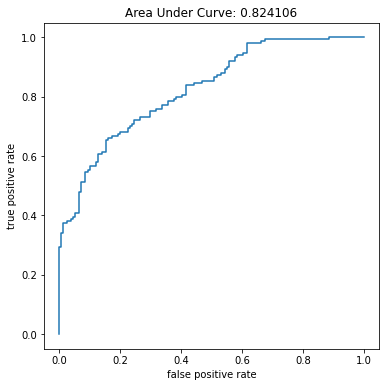

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_test[:, 0], y_pred[:, 0])

#sensitivity= (100*true_positive_rate)/(true_positive_rate+false_positive_rate)
#print(auc)
#print(sensitivity)

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

from result, added weight with augmented data leads to decrease in performance. 

Now, Network performance will be checked by increasing residual block before each maxpooling. 

In [ ]:
batch_size = 256
num_classes = 2
epochs = 40
input_shape=(10000, 1)

In [ ]:
##residual blocks+channel attention network. three residal blocks
#and channel attention  before each maxpooling.  
def channel_attention(input_feature, ratio=1):
  channel = input_feature.shape[2]
  shared_layer_one = Dense(channel // ratio,
                           activation='relu',
                           kernel_initializer='he_normal',
                           use_bias= True,
                           bias_initializer= 'zeros'
                           )
  avg_pool = GlobalAveragePooling1D()(input_feature)
  avg_pool = Reshape((1, channel))(avg_pool)
  avg_pool = shared_layer_one(avg_pool)

  max_pool = GlobalMaxPooling1D()(input_feature)
  max_pool = Reshape((1, channel))(max_pool)
  max_pool = shared_layer_one(max_pool)
  c_feature = Add()([avg_pool, max_pool])
  c_feature = Activation('sigmoid')(c_feature)
  return multiply([input_feature, c_feature])

def relu_bn(inputs):
  relu = tf.keras.layers.ReLU()(inputs)
  bn = BatchNormalization()(relu)
  return bn

def residual_block(x, kernel_size):
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)              
  y = relu_bn(y)
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)
  y = relu_bn(y)
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)
  y = relu_bn(y)
  y = Conv1D(kernel_size,5, strides=1,padding="same")(x)
  y = relu_bn(y) 
   
    
  out = Add()([x, y])
  out = relu_bn(out)
  return out

def get_net_2():

  inputs = Input(shape= (10000,1))


  #weights_initializer = RandomNormal(
          #mean=0.0, stddev=.01)
  conv1 = Conv1D(32, 5 , activation= 'relu')(inputs)
  conv1 = residual_block(conv1, 32)
  conv1 = residual_block(conv1, 32)
  conv1 = residual_block(conv1, 32)
  conv1= SpatialDropout1D(0.2)(conv1)
  conv1= channel_attention(conv1)
  pool1 = MaxPooling1D(pool_size=(5))(conv1)

  conv2 = Conv1D(64, 5 , activation= 'relu')(pool1)
  conv2 = residual_block(conv2, 64)
  conv2 = residual_block(conv2, 64)
  conv2 = residual_block(conv2, 64)
  conv2= SpatialDropout1D(0.2)(conv2)
  conv2= channel_attention(conv2)
  pool2 = MaxPooling1D(pool_size=(5))(conv2)

  conv3 = Conv1D(128, 5 , activation= 'relu')(pool2)
  conv3 = residual_block(conv3, 128)
  conv3 = residual_block(conv3, 128)
  conv3 = residual_block(conv3, 128)
  conv3= SpatialDropout1D(0.2)(conv3)
  conv3= channel_attention(conv3)
  pool3 = MaxPooling1D(pool_size=(5))(conv3)

  conv4 = Conv1D(128, 5 , activation= 'relu')(pool3)
  conv4 = residual_block(conv4, 128)
  conv4 = residual_block(conv4, 128)
  conv4 = residual_block(conv4, 128)
  conv4= SpatialDropout1D(0.2)(conv4)
  conv4= channel_attention(conv4)
  pool4 = MaxPooling1D(pool_size=(5))(conv4)

  i= Flatten()(pool4)
  h= Dense(256, activation='relu')(i)
  h= Dropout(0.5)(h)
  h= Dense(num_classes, activation=Activation(tf.nn.softmax))(h)
  model= Model(inputs= [inputs], outputs= [h])
  model.summary()
  return model

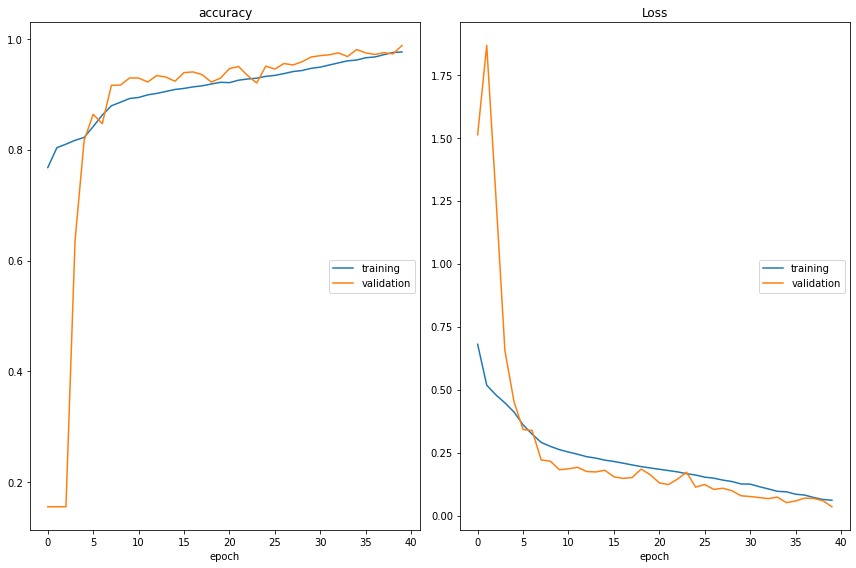

accuracy
	training         	 (min:    0.768, max:    0.976, cur:    0.976)
	validation       	 (min:    0.156, max:    0.988, cur:    0.988)
Loss
	training         	 (min:    0.061, max:    0.680, cur:    0.061)
	validation       	 (min:    0.035, max:    1.866, cur:    0.035)


In [ ]:
model= get_net_2()
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=Adam(learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07),
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
weights= {0:5, 1:1}
history = model.fit(
    x3_train, 
    y3_train,
    #class_weight= weights,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[es, PlotLossesKeras()],
    verbose=1,
    validation_split=0.2,
    shuffle=True,
)

In [ ]:
y_pred = model.predict(x_test)

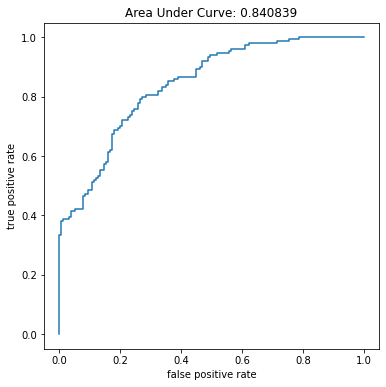

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test[:, 0], y_pred[:, 0])
auc = roc_auc_score(y_test[:, 0], y_pred[:, 0])

#sensitivity= (100*true_positive_rate)/(true_positive_rate+false_positive_rate)
#print(auc)
#print(sensitivity)

plt.figure(figsize=(6, 6))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Area Under Curve: %f' % auc)
plt.show()

from result, network performance increased with 3 resudal block before each maxpooling. However, when resdual block is further increased, it creates a memory allocation error. 

# Discussion
**Please discuss the algorithm performance and explain the changes you made which led to performance gains.**

Changes made: 

The given network is a 1D encoder network with 4 maxpooling and 2 convolution layer before each maxpooling. From observation, if convolution layer is increased before each maxpooling the AUC is decreased. Reason for decreasing AUC could be gradient vanishing problem.  To handle gradient vanshing problem, one of the techniques is to use residual network. So instead of convolution layer, another encoder network is used which consists of residual blocks intead of convolutional blocks before each maxpooling. Each residual block consists of 4 convolutional layer and before each maxpooling two residual blocks are used. This proposed network architecture increased the network parameter and when the network is trained without any augmentation in the training data, the AUC decreased with value around ~0.66. But when network is trained with augmented dataset with adjusted hyperparameter ( learning rate= 0.0001, batch size= 256, early stopping with patience 5), AUC increased. Data augmentation is performed by adding gaussian noise and time series shifting of the data. After each residual block a channel attention is used to capture inter channel relationship and give weight to the important features in the channel before maximum pooling. A dropout layer is used before channel attention which helps the network to better generalize on the unseen dataset. At first two residual block before each maxpooling is used which gives AUC= ~0.83, when residual block is increased as three residual blocks before each maxpooling the resulted AUC is ~0.84. However when residual block is further increased memory allocation error was shown.  

Observations: 
Several observations were made from the above experiements- 
1. The given encoder network gives an AUC performance of 0.76. As the training dataset is slightly imbalanced, class weights were used in the training data (without augmentation) which improves the AUC value as 0.77. However, when the proposed residual+attention encoder network is trained with augmented data and without any class weights the network performance is slightly better than training network with class weights and augmented training data.  

2. If only residual blocks are used without channel attention the network performance is AUC= ~ 0.82. using channel attention improves the network performances by AUC= ~0.84. 

3. For imbalanced dataset focal loss sometimes gives better performance. However, if focal loss and class weight both are used, the performance further deteriorates.

4. If the convolutional filter number is increased with increased maxpoooling the AUC performance deteriorats.  

**Please discuss other things you would try if you had additional time that might further improve performance.**

Other things I would try if I have time is to use a single Resnet with dense layer at the end to check how the architecture performs. However, from my previous experience, generally, residual block in encoder network performs better than a single resnet. Also I would like to try how recurrent neural network performs in the classification. 

Another way I would like to try is converting the audio data into spectogram. As the spectograms are fourier transform of the sound signal and plots frequency vs time and uses colors to indicate amplitude of each frequency,  it would be interesting to see how neural network architecture performs detecting normal and abnormal heart sound using those features. Also I would like to explore the possibility of using both time series feature from raw data and spectogram feature both, either in loss function or in the architecture. 

